# Sparkify - Capstone Project

In [1]:
# import libraries

# for local execution
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 6)})
sns.set_style("whitegrid")
sns.set_palette("Paired")


In [3]:
# create a Spark session
#sc = pyspark.SparkContext()

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


# Load and Clean Dataset


In [5]:
path = "../data/medium-sparkify-event-data.json"
event_data_df = spark.read.json(path)

In [6]:
event_data_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
event_data_df.count()

543705

### Available visited pages

In [8]:
event_data_df.select("page").dropDuplicates().sort("page").show(n=50, truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Login                    |
|Logout                   |
|NextSong                 |
|Register                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Registration      |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



### Check for and remove missing values in `userId` and `sessionId` fields

In [9]:
# Check for Null values in sessionId and userId
print(f'sessionIds with Null values: {event_data_df.filter(F.col("sessionId").isNull()).count()}')
print(f'userIds with Null values: {event_data_df.filter(F.col("userId").isNull()).count()}')

sessionIds with Null values: 0
userIds with Null values: 0


In [10]:
# Check for empty strings in sessionId and userId
print(f'userIds that are empty strings: {event_data_df.filter(F.col("userId") == "").count()}')
print(f'sessionIds that are empty strings: {event_data_df.filter(F.col("sessionId") == "").count()}')

userIds that are empty strings: 15700
sessionIds that are empty strings: 0


In [11]:
event_data_cleaned_df = event_data_df.filter(F.col("userId") != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Add column `churned` using `Cancellation Confirmation` page visit of a user as an indication

In [12]:
from pyspark.sql import Window

In [13]:
window_partitioning = Window.partitionBy("userId")

churn_data_df = (event_data_cleaned_df
                 .withColumn("cancelled", F.col("page") == "Cancellation Confirmation")
                 .withColumn("Churn", F.max(F.col("cancelled")).over(window_partitioning))
                )


In [14]:
# Count the distinct number of users who churned
dct_users_churned = churn_data_df.filter(F.col("Churn") == True).select("userId").distinct().count()
# Count the distinct number of users who have not (yet) churned
dct_users_retained = churn_data_df.filter(F.col("Churn") == False).select("userId").distinct().count()

print(f"Number of users churned: {dct_users_churned}")
print(f"Number of users retained: {dct_users_retained}")
print(f"Total Number of users: {dct_users_churned + dct_users_retained}")

Number of users churned: 99
Number of users retained: 349
Total Number of users: 448


#### Remove users who have started using the service only recently
For users who signed up close to the dataset's end date the fact that they have not cancelled yet might be just due to the limited usage time. However, it is likely that some of these users will churn in the following days or weeks.

For this reason the average usage time for users that churned is calculated and users that have been using the service for less than that time period are removed. 


In [15]:
# Add usage time column to data for each user
#churn_data_df = churn_data_df.withColumn("usage_time_overall", 
#                                         F.max("ts").over(window_partitioning)
#                                         - F.min("ts").over(window_partitioning))


In [16]:
# Calculate time until cancellation
#mean_usage_time_churned = (churn_data_df
#                           .groupBy("userId", "Churn")
#                           .agg((F.max("ts") - F.min("ts")).alias("approx_usage_time"))
#                           .groupBy("Churn")
#                           .agg(F.mean(F.col("approx_usage_time")).alias("mean_approx_usage_time"))
#                           .filter(F.col("Churn") == True)
#                           .collect()[0]["mean_approx_usage_time"]
#                          )
#
#print(f"Average time until a user churned: {mean_usage_time_churned}")

In [17]:
churn_data_filtered_df = churn_data_df
#churn_data_filtered_df = churn_data_df.filter(F.col("usage_time_overall") > mean_usage_time_churned)
#
#count_users_filtered = churn_data_filtered_df.select("userId").distinct().count()
#
#print(f"Number of considered users: {count_users_filtered}")

In [18]:
churn_data_filtered_df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, cancelled: boolean, Churn: boolean]

In [19]:
(churn_data_filtered_df
 .groupBy("userId", "Churn", "registration")
 .agg((F.max(F.col("ts")) - F.col("registration")).alias("duration"))
 .groupBy("Churn")
 .agg(F.mean(F.col("duration")).alias("avgAccountLifeTime"))
).show()


+-----+-------------------+
|Churn| avgAccountLifeTime|
+-----+-------------------+
| true|5.872436919191919E9|
|false|7.521008908309456E9|
+-----+-------------------+



In [20]:
# Compare events of churned and retained users
avgEventsPerSessionByChurn = (churn_data_filtered_df
                    .filter(F.col("page") != "Cancellation Confirmation")
                    .withColumn("countSessionIds", F.size(F.collect_set(F.col("sessionId")).over(Window.partitionBy("Churn"))))
                    .groupBy("Churn", "page")
                    .agg((F.count(F.col("page")) / F.first(F.col("countSessionIds"))).alias("avgEventsPerSession"),
                          F.count(F.col("page")).alias("countPages"))
                    .orderBy(F.desc("avgEventsPerSession"), "Churn", "page")
                   )

avgEventsPerSessionByChurn.show()

+-----+---------------+-------------------+----------+
|Churn|           page|avgEventsPerSession|countPages|
+-----+---------------+-------------------+----------+
|false|       NextSong|  90.26625226625227|    348518|
| true|       NextSong|  78.69309701492537|     84359|
|false|      Thumbs Up|  5.057239057239057|     19526|
| true|      Thumbs Up| 4.0111940298507465|      4300|
|false|           Home| 3.9655529655529658|     15311|
| true|           Home| 3.5242537313432836|      3778|
|false|Add to Playlist|  2.613312613312613|     10090|
| true|Add to Playlist|  2.107276119402985|      2259|
| true|    Roll Advert| 2.0391791044776117|      2186|
|false|     Add Friend| 1.6964516964516965|      6550|
|false|    Roll Advert|  1.447034447034447|      5587|
| true|     Add Friend| 1.4337686567164178|      1537|
|false|         Logout| 1.2447552447552448|      4806|
| true|         Logout| 1.1044776119402986|      1184|
| true|    Thumbs Down|  1.078358208955224|      1156|
|false|   

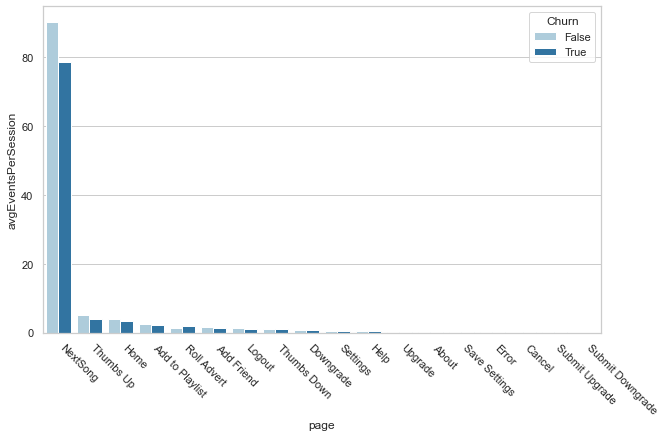

In [21]:
ax = sns.barplot(data=avgEventsPerSessionByChurn.toPandas(), x="page", y="avgEventsPerSession", hue="Churn")
plt.xticks(rotation=-45, horizontalalignment="left");


Users who churned had a lower average of songs per session than users who did not. 

Since the values for `NextSong` differ too much to judge the difference, here's a diagram without the `NextSong` page.

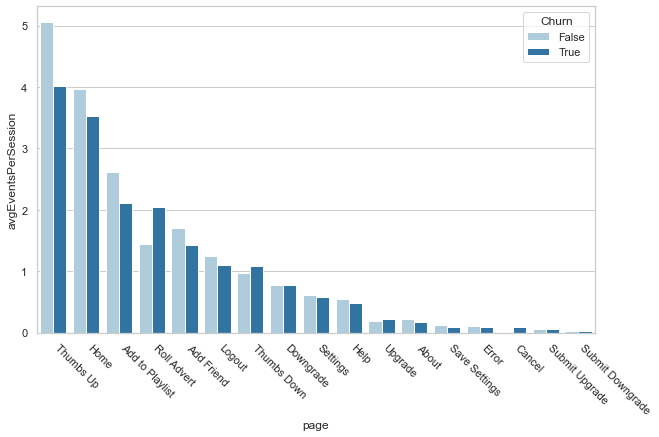

In [22]:
ax = sns.barplot(data=avgEventsPerSessionByChurn.filter(F.col("page") != "NextSong").toPandas(), x="page", y="avgEventsPerSession", hue="Churn")
plt.xticks(rotation=-45, horizontalalignment="left");


For most of the pages the event ratio of actions is similar between users who churned and those who have not yet churned. 

The most significant difference can be seen for the `Thumbs Up` and `Roll Advert` page. Users who churned give less `Thumbs up` indicating that the available or recommended music does not reflect their music taste. Therefore, the count of `Roll Advert` events is considered as a feature. 

Further page counts that might hint at a potential discriminating factor between users who churned and those who didn't are:
- `Thumbs Down`: The ratio for this event is aligned with the one for `Thumbs Up`: the users who churned gave more `Thumbs Down` than users who did not.
- `Add Friend` & `Add to Playlist`: Users who churned used the app features slightly fewer times than users who did not.
- `Help` & `Settings`: Users who churned interacted less with the service. 

(Interestingly, users that had a paid plan before, churned more often than those who never upgraded. The reasons behind this could be manifold; two potential explanation might be that users did not know they could back to the free plan by submitting a downgrade and cancelled instead. Another explanation might be that users who upgraded were not satisfied with the free offer and therefore tried the paid plan which did not fulfill their expectations either.)


##### Average listening time before selecting next song

In [23]:
avg_length_by_churn = (churn_data_filtered_df
                       .select("length", "page", "Churn")
                       .orderBy("length")
                       .filter(F.col("page") == "NextSong")
                       .groupBy("Churn")
                       .agg(F.mean(F.col("length")), F.stddev_pop(F.col("length")))
                      )

In [24]:
avg_length_by_churn.show()

+-----+------------------+------------------+
|Churn|       avg(length)|stddev_pop(length)|
+-----+------------------+------------------+
| true|248.99398360601714| 98.49219687546936|
|false| 248.5848635245238| 98.39310327670415|
+-----+------------------+------------------+



##### Average number of songs per Session

In [25]:
avg_songs_per_session_by_churn = (churn_data_filtered_df
                                  .select("sessionId", "page", "Churn")
                                  .filter(F.col("page") == "NextSong")
                                  .groupBy("sessionId", "Churn")
                                  .count()
                                  .groupBy("Churn")
                                  .agg(F.mean(F.col("count")).alias("avg_songs_per_session"))
                                 )

In [26]:
avg_songs_per_session_by_churn.show()

+-----+---------------------+
|Churn|avg_songs_per_session|
+-----+---------------------+
| true|    80.72631578947369|
|false|    92.22492722942577|
+-----+---------------------+



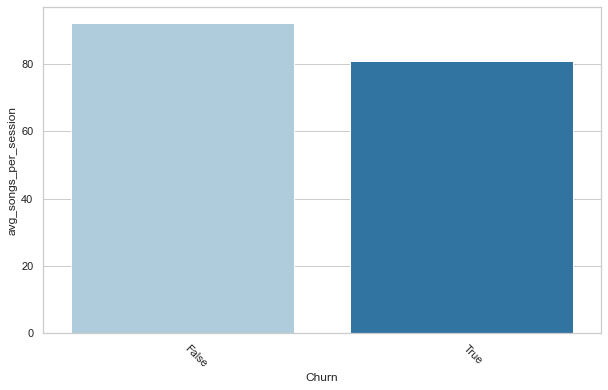

In [27]:
ax = sns.barplot(data=avg_songs_per_session_by_churn.toPandas(), x="Churn", y="avg_songs_per_session")
plt.xticks(rotation=-45, horizontalalignment="left");

##### Number of artists

In [28]:
churn_data_filtered_df.groupBy("userId", "Churn").agg(F.countDistinct(F.col("artist"))).groupBy("Churn").mean().show()


+-----+------------------+
|Churn|avg(count(artist))|
+-----+------------------+
| true| 592.7373737373738|
|false| 677.7707736389685|
+-----+------------------+



##### Number of songs

In [29]:
churn_data_filtered_df.groupBy("userId", "Churn").agg(F.countDistinct(F.col("song"))).groupBy("Churn").mean().show()


+-----+-----------------+
|Churn| avg(count(song))|
+-----+-----------------+
| true|756.6161616161617|
|false|879.3782234957021|
+-----+-----------------+



In [30]:
# Converted date does not make sense
#churn_data_df.withColumn("time", F.to_timestamp(F.col("ts"))).select("time").show(truncate=False)

##### Churn by gender

In [31]:
churn_by_gender = (churn_data_filtered_df
                   .select("userId", "Churn", "gender")
                   .distinct()
                   .groupBy("Churn", "gender")
                   .count()
                   .withColumn("ratio", F.col("count") / F.sum(F.col("count")).over(Window.partitionBy("gender")))
                  )

churn_by_gender.show()


+-----+------+-----+-------------------+
|Churn|gender|count|              ratio|
+-----+------+-----+-------------------+
| true|     F|   45|0.22727272727272727|
|false|     F|  153| 0.7727272727272727|
|false|     M|  196|              0.784|
| true|     M|   54|              0.216|
+-----+------+-----+-------------------+



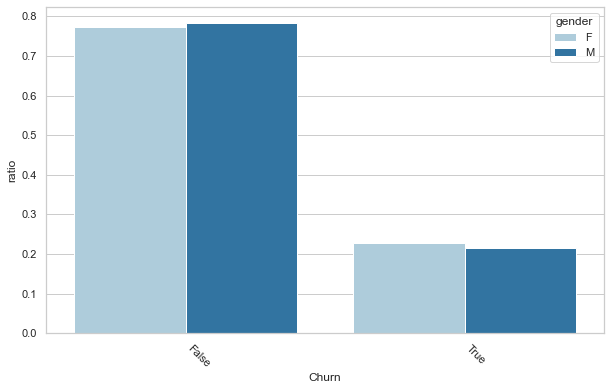

In [32]:
ax = sns.barplot(data=churn_by_gender.toPandas(), x="Churn", y="ratio", hue="gender")
plt.xticks(rotation=-45, horizontalalignment="left");


##### Churn by location

In [33]:
churn_by_state = (churn_data_filtered_df
                  .withColumn("state", F.substring(F.col("location"), -2, 2))
                  .select("userId", "Churn", "state")
                  .distinct()
                  .groupBy("Churn", "state")
                  .count()
                  .withColumn("ratio", F.col("count") / F.sum(F.col("count")).over(Window.partitionBy("state")))
                  )
                

churn_by_state.show()

+-----+-----+-----+-------------------+
|Churn|state|count|              ratio|
+-----+-----+-----+-------------------+
| true|   AZ|    2|                0.2|
|false|   AZ|    8|                0.8|
| true|   SC|    2|0.16666666666666666|
|false|   SC|   10| 0.8333333333333334|
| true|   LA|    2|                0.4|
|false|   LA|    3|                0.6|
|false|   MN|    3|                1.0|
| true|   NJ|    3|                0.5|
|false|   NJ|    3|                0.5|
| true|   OR|    1| 0.3333333333333333|
|false|   OR|    2| 0.6666666666666666|
| true|   VA|    2| 0.3333333333333333|
|false|   VA|    4| 0.6666666666666666|
| true|   KY|    3|               0.75|
|false|   KY|    1|               0.25|
|false|   NH|    8|                0.8|
| true|   NH|    2|                0.2|
|false|   MI|    8| 0.7272727272727273|
| true|   MI|    3| 0.2727272727272727|
|false|   NV|    3|                1.0|
+-----+-----+-----+-------------------+
only showing top 20 rows



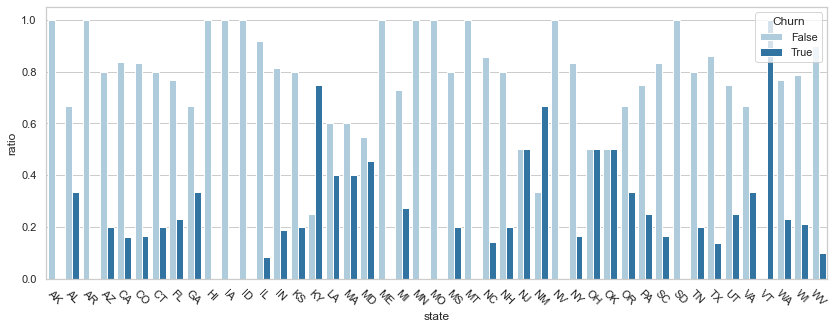

In [142]:
plt.figure(figsize=(14,5))
ax = sns.barplot(data=churn_by_state.orderBy("state").toPandas(), x="state", y="ratio", hue="Churn")
plt.xticks(rotation=-45);

Limitation: Due to the limited dataset size used, some states only have very few records. The validity is therefore expected to be limited.

##### Churn by device/access

In [35]:
churn_by_device = (churn_data_filtered_df
                   .select("userId", "userAgent", "Churn")
                   .distinct()
                   .withColumn("device", F.regexp_extract(F.col("userAgent"), r"(?<=\()([^();]*(?=\;))", 0))
                   .groupBy("Churn", "device")
                   .count()
                   .withColumn("ratio", F.col("count") / F.sum(F.col("count")).over(Window.partitionBy("device")))
                   .replace("", "unknown", ["device"])
                  )

churn_by_device.show()

+-----+--------------+-----+-------------------+
|Churn|        device|count|              ratio|
+-----+--------------+-----+-------------------+
|false|          iPad|    9|                1.0|
|false|           X11|   21| 0.8076923076923077|
| true|           X11|    5|0.19230769230769232|
| true|Windows NT 6.3|    6|0.16666666666666666|
|false|Windows NT 6.3|   30| 0.8333333333333334|
|false|        iPhone|    7| 0.3888888888888889|
| true|        iPhone|   11| 0.6111111111111112|
|false|Windows NT 6.2|   10| 0.6666666666666666|
| true|Windows NT 6.2|    5| 0.3333333333333333|
| true|     Macintosh|   35| 0.2023121387283237|
|false|     Macintosh|  138| 0.7976878612716763|
| true|Windows NT 5.1|    1|                1.0|
|false|    compatible|   11| 0.8461538461538461|
| true|    compatible|    2|0.15384615384615385|
|false|Windows NT 6.0|    1|                1.0|
| true|Windows NT 6.1|   30|0.21897810218978103|
|false|Windows NT 6.1|  107|  0.781021897810219|
|false|       unknow

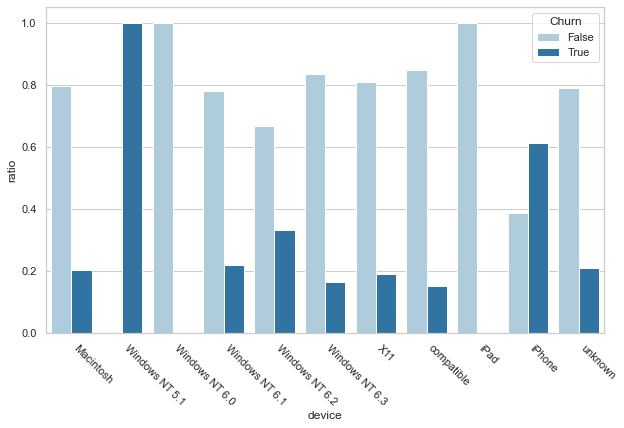

In [144]:
ax = sns.barplot(data=churn_by_device.orderBy("device").toPandas(), x="device", y="ratio", hue="Churn")
plt.xticks(rotation=-45, horizontalalignment="left");

##### Level in which the user was when she cancelled

In [37]:
churn_by_level = (churn_data_filtered_df
                  .filter(F.col("page") == "Cancellation Confirmation")
                  .groupBy("level")
                  .count()
                  .withColumn("ratio", F.col("count") / F.sum(F.col("count")).over(Window.partitionBy()))
                 )

churn_by_level.show()

+-----+-----+-------------------+
|level|count|              ratio|
+-----+-----+-------------------+
| free|   32|0.32323232323232326|
| paid|   67| 0.6767676767676768|
+-----+-----+-------------------+



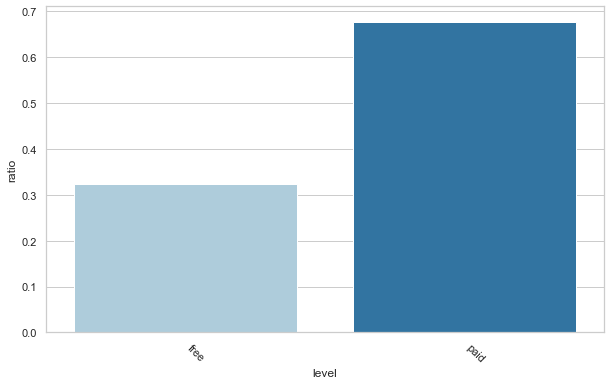

In [38]:
ax = sns.barplot(data=churn_by_level.toPandas(), x="level", y="ratio")
plt.xticks(rotation=-45, horizontalalignment="left");

At the time when users churned more users had been using a paid plan.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Feature extraction

In [39]:
# Check that length only exists for "NextSong" page records
# churn_data_filtered_df.filter(F.col("length").isNotNull()).select("page").distinct().show()

In [40]:
# Aggregate dataframe to user level
data_agg_by_user_df = (churn_data_filtered_df
                       .withColumn("device", F.regexp_extract(F.col("userAgent"), r"(?<=\()([^();]*(?=\;))", 0))
                       .withColumn("state", F.substring(F.col("location"), -2, 2))
                       .withColumn("latestLevel", F.last("level").over(Window.partitionBy("userId").orderBy("ts")))
                       .withColumn("accountLifeTime", F.max("ts").over(Window.partitionBy("userId")) - F.col("registration"))
                       .filter(F.col("page").isin("NextSong", "Roll Advert", "Thumbs Down", "Add Friend", 
                                                  "Settings", "Help", "Add to Playlist"))
                       .groupBy("userId") # Aggregate per User
                       .agg(F.countDistinct("song").alias("countSongs"),
                            F.countDistinct("artist").alias("countArtists"),
                            F.collect_list("page").alias("pages"), 
                            F.countDistinct("sessionId").alias("countSessions"),
                            F.mean(F.col("length")).alias("avgLength"), 
                            F.stddev_pop(F.col("length")).alias("stdDevLength"),
                            F.collect_set("device").alias("devices"),
                            F.collect_set("state").alias("states"),
                            F.first("gender").alias("gender"),
                            F.first("latestLevel").alias("latestLevel"),
                            F.first("accountLifeTime").alias("accountLifeTime"),
                            F.max("Churn").alias("label")
                           )
                       .withColumn("countSessionsInverse", F.lit(1) / F.col("countSessions"))
                       .withColumn("label", F.when(F.col("label") == True, 1.0).otherwise(0.0))
                   )


In [41]:
# import required classes
from pyspark.ml.feature import CountVectorizer, StringIndexer, OneHotEncoder, \
                               Interaction, VectorAssembler, StandardScaler


#### CountVectorizer: `pages`, `devices`, `states` 

In [42]:
# Use CountVectorizer on "devices" and "states" for cases when one uses accesses the service 
# from different devices/OS and/or states
cv_cols_in = ["pages", "devices", "states"]
cv_cols_out = [cv_col_in + "_cv" for cv_col_in in cv_cols_in]

In [43]:
cvs = [CountVectorizer(inputCol=cv_col_in, outputCol=cv_col_out) \
       for cv_col_in, cv_col_out in zip(cv_cols_in, cv_cols_out)]


#### Interaction: Calculation of average counts of pages per session per user

In [44]:
# Convert column "countSessionsInverse" into a vector to work with "Interaction"
va1 = VectorAssembler(inputCols=["countSessionsInverse"], outputCol="countSessionsInverseVec_va1")


In [45]:
ia = Interaction(inputCols=["pages_cv", "countSessionsInverseVec_va1"], outputCol="pages_ia")


#### StringIndexer & OneHotEncoder: `gender`, `latestLevel`

In [46]:
si_cols_in = ["gender", "latestLevel"]
si_cols_out = [si_col_in + "_si" for si_col_in in si_cols_in]

si = StringIndexer(inputCols=si_cols_in, outputCols=si_cols_out)

ohe_cols_in = si_cols_out
ohe_cols_out = [si_col_in + "_ohe" for si_col_in in si_cols_in]
ohe = OneHotEncoder(inputCols=ohe_cols_in, outputCols=ohe_cols_out)

#### VectorAssembler: Assemble all feature columns

In [47]:
features = ["devices_cv", "states_cv", "pages_ia", "gender_ohe", "latestLevel_ohe",
            "avgLength", "stdDevLength", "countSessions", "countArtists", "countSongs"]
va2 = VectorAssembler(inputCols=features, outputCol="features")

#### Standardize features

In [48]:
ss = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaledFeatures")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Split data

In [49]:
trainValSet, testSet = data_agg_by_user_df.randomSplit([0.8, 0.2], seed=42)

### Models

#### Logistic Regression

In [50]:
from pyspark.ml.classification import LogisticRegression

In [51]:
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label")


#### Random Forest Classifier

In [52]:
# Set Checkpoint directory for rfc 
spark.sparkContext.setCheckpointDir("tmp/checkpoints")

In [53]:
from pyspark.ml.classification import RandomForestClassifier

In [54]:
rfc = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label")


#### Gradient-Boosted Trees Classifier

In [55]:
from pyspark.ml.classification import GBTClassifier

In [56]:
gbtc = GBTClassifier(featuresCol="scaledFeatures", labelCol="label")


#### Linear Support Vector Machine

In [57]:
from pyspark.ml.classification import LinearSVC

In [58]:
lsvc = LinearSVC(featuresCol="scaledFeatures", labelCol="label")

### Pipeline Creation

In [59]:
from pyspark.ml import Pipeline


In [60]:
def make_pipeline(feature_preprocessing_list, classifier=None):
    """
    Returns a Pipeline object with stages given by inputs.
    
    Parameters
    ----------
    feature_preprocessing_list : list of pyspark.ml.feature objects
        Specifies list of feature preprocessing stages.
    classifier : pyspark.ml.classification object
        Specifies classifier to be used in Pipeline
        
    Returns
    -------
    pyspark.ml.pipeline.Pipeline object
        
    """
    stages = feature_preprocessing_list
    if classifier is not None:
        stages = stages + [classifier]    
    return Pipeline(stages=stages)

In [61]:
feature_preprocessing = [*cvs, va1, ia, si, ohe, va2, ss]


### Train Models

In [62]:
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder

In [63]:
f1Evaluator = MulticlassClassificationEvaluator(metricName="fMeasureByLabel", metricLabel=1.0, 
                                                predictionCol='prediction', labelCol='label')

In [64]:
# set path for trained models
path = "models/"

In [65]:
def train_model(pipeline, paramGrid, evaluator, trainValSet):
    """
    Find the best model for a training set and return the trained model.
    
    Parameters
    ----------
    pipeline : pyspark.ml.pipeline object
        
    paramGrid : 
        Grid of parameters to search built with ParamGridBuilder() from pyspark.ml.tuning
    evaluator : 
        Specifies evaluator object to evaluate the training results.
    trainValSet : dataframe
        
    Returns
    -------
    pyspark.ml.tuning.TrainValidationSplit object fit to trainValSet
    
    """
    tvs = TrainValidationSplit(estimator=pipeline,
                               estimatorParamMaps=paramGrid,
                               evaluator=evaluator,
                               # 80% of the data will be used for training, 20% for validation.
                               trainRatio=0.8,
                               collectSubModels=True)
    return tvs.fit(trainValSet)

def save_tvs_model(tvsModel, path, modelName):
    """
    Saves the provided TrainValidationSplit model to path.
    
    Parameter
    --------
    tvsModel : pyspark.ml.tuning.TrainValidationSplit object
        Model to save.
    path : str
        Path for model.
    modelName : str
        Custom model name.
    
    """
    model_path = path + modelName
    tvsModel.write().overwrite().save(model_path)


In [69]:
lrPipeline = make_pipeline(feature_preprocessing, lr)
lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.0, 1.0, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
               .build())

trainedLrModel = train_model(lrPipeline, lrParamGrid, f1Evaluator, trainValSet)
save_tvs_model(trainedLrModel, path, "lrModel")

In [70]:
trainedLrModel.validationMetrics

[0.14285714285714285]

In [72]:
rfcPipeline = make_pipeline(feature_preprocessing, rfc)
rfcParamGrid = (ParamGridBuilder()
                .addGrid(rfc.maxDepth, [2, 5, 15, 30])
                .addGrid(rfc.numTrees, [100])
                .addGrid(rfc.minInstancesPerNode, [1, 2, 5])
                .addGrid(rfc.seed, [42])
                .build())

trainedRfcModel = train_model(rfcPipeline, rfcParamGrid, f1Evaluator, trainValSet)
save_tvs_model(trainedRfcModel, path, "rfcModel")


In [ ]:
trainedRfcModel.validationMetrics

In [130]:
gbtcPipeline = make_pipeline(feature_preprocessing, gbtc)
gbtcParamGrid = (ParamGridBuilder()
                  .addGrid(gbtc.maxDepth, [2, 5, 15, 30])
                  .addGrid(gbtc.stepSize, [0.05, 0.1, 0.3])
                  .addGrid(gbtc.subsamplingRate, [1])
                  .addGrid(gbtc.seed, [42])
                  .build())

trainedGbtcModel = train_model(gbtcPipeline, gbtcParamGrid, f1Evaluator, trainValSet)
save_tvs_model(trainedgbtcModel, path, "gbtcModel")


In [ ]:
trainedGbtcModel.validationMetrics

In [77]:
lsvcPipeline = make_pipeline(feature_preprocessing, lsvc)
lsvcParamGrid = (ParamGridBuilder()
                  .addGrid(lsvc.regParam, [0, 0.1, 0.2, 0.5])
                  .addGrid(lsvc.standardization, [False])
                  .build())

trainedLsvcModel = train_model(lsvcPipeline, lsvcParamGrid, f1Evaluator, trainValSet)
save_tvs_model(trainedLsvcModel, path, "lsvcModel")

In [78]:
trainedLsvcModel.validationMetrics

[0.0909090909090909, 0.09999999999999999, 0.0, 0.0]

### Test Models on Test Set

In [82]:
from pyspark.ml.tuning import TrainValidationSplitModel # Needed for loading the model

def read_tvs_model(path, modelName):
    """
    Reads and returns a stored model. 
    
    Parameters
    ----------
    path : str
        Path to model.
    modelName : str
        Model name.
    
    Returns
    -------
    pyspark.ml.tuning.TrainValidationSplit object
    
    """
    model_path = path + modelName
    tvsModel = TrainValidationSplitModel.read().load(model_path)
    return tvsModel

def evaluate_model(model, testSet, metric="fMeasureByLabel"):
    """
    Parameters
    ----------
    model : pyspark.ml model object 
        Specifies a fit model to be evaluated.
    testSet : dataframe
        Dataframe for which prediction are evaluated.
    metric : {"fMeasureByLabel", "f1", "recallByLabel", "precisionByLabel"}, default="fMeasureByLabel"
        Specifies the metric to calculate. Takes all metrics available in MulticlassClassificationEvaluator
    
    Returns
    -------
    The result for the specified metric on the test set.
    
    """
    result = model.transform(testSet)
    
    evaluator = MulticlassClassificationEvaluator(metricName=metric, metricLabel=1.0)
    
    return evaluator.evaluate(result)

#### Logistic Regression - Results

In [115]:
lrModel = trainedLrModel.bestModel #read_tvs_model(path, "lrModel")
print(f"f1-score: {evaluate_model(lrModel, testSet, 'fMeasureByLabel')}")
print(f"Recall: {evaluate_model(lrModel, testSet, 'recallByLabel')}")
print(f"Precision: {evaluate_model(lrModel, testSet, 'precisionByLabel')}")

f1-score: 0.1904761904761905
Recall: 0.2
Precision: 0.18181818181818182


In [87]:
lrPred = lrModel.transform(testSet)

In [88]:
lrPred.select("label", "prediction").groupBy("label").pivot("prediction").count().show()

+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|  0.0| 60|  9|
|  1.0|  8|  2|
+-----+---+---+



#### Random Forest - Results

In [89]:
rfcModel = trainedRfcModel.bestModel #  = read_tvs_model(path, "rfcModel")


0.7951113051069402


In [102]:
print(f"f1-score: {evaluate_model(rfcModel, testSet, 'fMeasureByLabel')}")
print(f"Recall: {evaluate_model(rfcModel, testSet, 'recallByLabel')}")
print(f"Precision: {evaluate_model(rfcModel, testSet, 'precisionByLabel')}")

f1-score: 0.0
Recall: 0.0
Precision: 0.0


In [90]:
rfcPred = rfcModel.transform(testSet)

In [91]:
rfcPred.select("label", "prediction").groupBy("label").pivot("prediction", values=[0.0, 1.0]).count().show()

+-----+---+----+
|label|0.0| 1.0|
+-----+---+----+
|  0.0| 66|   3|
|  1.0| 10|null|
+-----+---+----+



#### Gradient-Boosted Trees - Results

In [105]:
gbtcModel = trainedGbtcModel.bestModel


In [106]:
print(f"f1-score: {evaluate_model(gbtcModel, testSet, 'fMeasureByLabel')}")
print(f"Recall: {evaluate_model(gbtcModel, testSet, 'recallByLabel')}")
print(f"Precision: {evaluate_model(gbtcModel, testSet, 'precisionByLabel')}")

f1-score: 0.0
Recall: 0.0
Precision: 0.0


In [107]:
gbtcPred = gbtcModel.transform(testSet)

In [108]:
gbtcPred.select("label", "prediction").groupBy("label").pivot("prediction").count().show()

+-----+---+----+
|label|0.0| 1.0|
+-----+---+----+
|  0.0| 63|   6|
|  1.0| 10|null|
+-----+---+----+



#### Linear Support Vector Machine - Results

In [109]:
lsvcModel = trainedLsvcModel.bestModel

In [113]:
print(f"f1-score: {evaluate_model(lsvcModel, testSet, 'fMeasureByLabel')}")
print(f"Recall: {evaluate_model(lsvcModel, testSet, 'recallByLabel')}")
print(f"Precision: {evaluate_model(lsvcModel, testSet, 'precisionByLabel')}")

f1-score: 0.25
Recall: 0.2
Precision: 0.3333333333333333


In [111]:
lscvPred = lsvcModel.transform(testSet)

In [112]:
lscvPred.select("label", "prediction").groupBy("label").pivot("prediction").count().show()

+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|  0.0| 65|  4|
|  1.0|  8|  2|
+-----+---+---+

